# Optiver Trading Assignment - Justin Lee 

# Dataset Exploration

Lets begin by plotting the midprice of both instruments together to get a high-level visual view of the data. 

In [3]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Read in data
all_data = pd.read_csv('final_data_10s.csv', parse_dates=True)
all_data['Time'] = pd.to_datetime(all_data['Time']) # Convert to datetime objects 
all_data.set_index('Time', inplace=True)  

# Compute the mid price for both instruments as an averaged metric of value
midprices = pd.DataFrame({'X_MID' : (all_data['X_ASK']+all_data['X_BID'])/2, 
                          'Y_MID' : (all_data['Y_ASK']+all_data['Y_BID'])/2}, index=all_data.index)

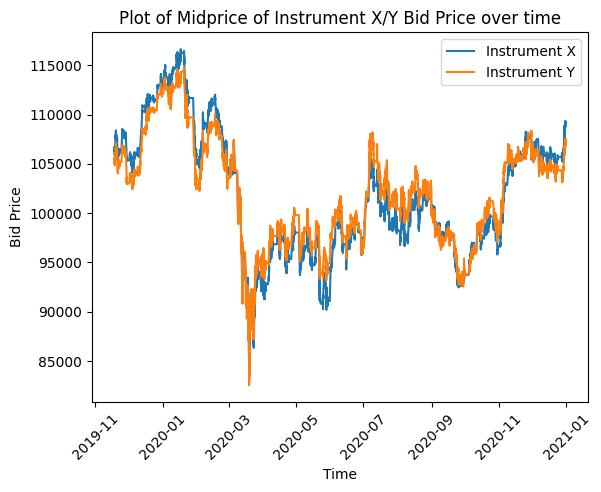

In [5]:
plt.plot(all_data.index, midprices['X_MID'], label="Instrument X")
plt.plot(all_data.index, midprices['Y_MID'], label="Instrument Y")
plt.title('Plot of Midprice of Instrument X/Y Bid Price over time')
plt.xlabel('Time')
plt.ylabel('Bid Price')
plt.legend()
plt.xticks(rotation=45) 
plt.show()

- Lacking real-world context for the financial instruments and their data there is not much information we can glean from this graph, however we can take a **practical** approach and observe that the instruments showed reasonably normal movement over the course of 2020, experiencing mild volatility and a distinct drop-off in March 2020, most likely as a result of the emergence of (assumedly) COVID-19.
- The most distinct and natural observation is the **strong correlation** between the midprices of the two instruments. 
    - Independent to the state of the market, the two appear to move together. 
    - We observe that the midprice of instrument X hovered above instrument Y prior to March, and then ducked beneath in the follow months up until around September, where the midprices of the two instruments stayed mostly in unison.
- We can validate this correlation using Pearson correlation 
- Let's zoom in on an arbitrarily chosen subsection of the year in higher resolution to see if we can make out the characteristics of their correlation. 

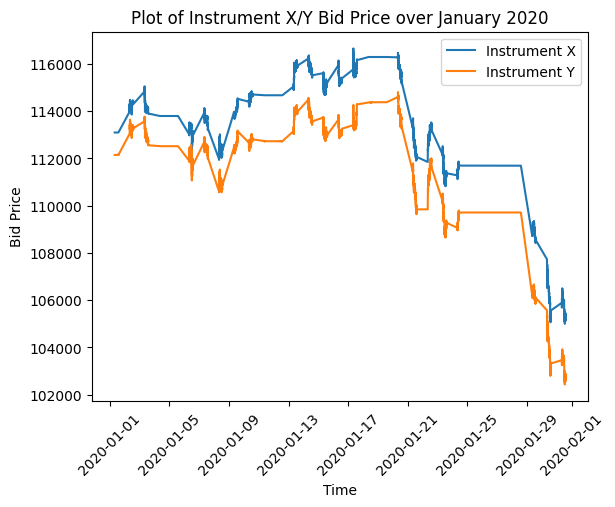

In [6]:
# Extremely high correlation is shown. Even at a micro-scale, the two instruments appear to move together. 

condensedAllData = midprices.loc['2020-01-01':'2020-01-31']
plt.plot(condensedAllData.index, condensedAllData['X_MID'], label="Instrument X")
plt.plot(condensedAllData.index, condensedAllData['Y_MID'], label="Instrument Y")
plt.title('Plot of Instrument X/Y Bid Price over January 2020')
plt.xlabel('Time')
plt.ylabel('Bid Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Validating Correlation

In [7]:
# Let's test the colleration using Pearson correlation. 
correlation = midprices['X_MID'].corr(midprices['Y_MID'], method='pearson')
print('The correlation between the mid value of instrument X and instrument Y is: ', round(correlation, 3))

The correlation between the mid value of instrument X and instrument Y is:  0.979


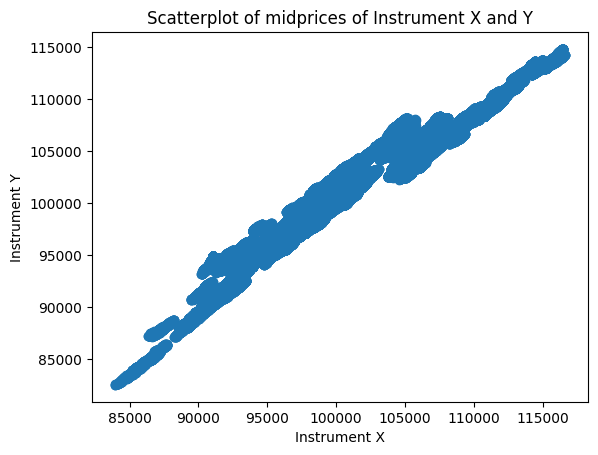

In [8]:
# Scatterplot 
plt.title('Scatterplot of midprices of Instrument X and Y')
plt.scatter(midprices['X_MID'], midprices['Y_MID'])
plt.xlabel('Instrument X')
plt.ylabel('Instrument Y')
plt.show()

### Results
Having numerically validated that the two instruments are very **highly correlated** (0.979), we can create two new time series: the spread of X and Y, and the ratio of X and Y, in order to understand more about the relationship between the two instruments. <br>
In the next section, we will investigate the long term correlation between them.

$$\text{Spread} = X - Y$$
$$\text{Ratio} = X / Y$$

*Note that we are still using the midprice of X and Y respectively.*

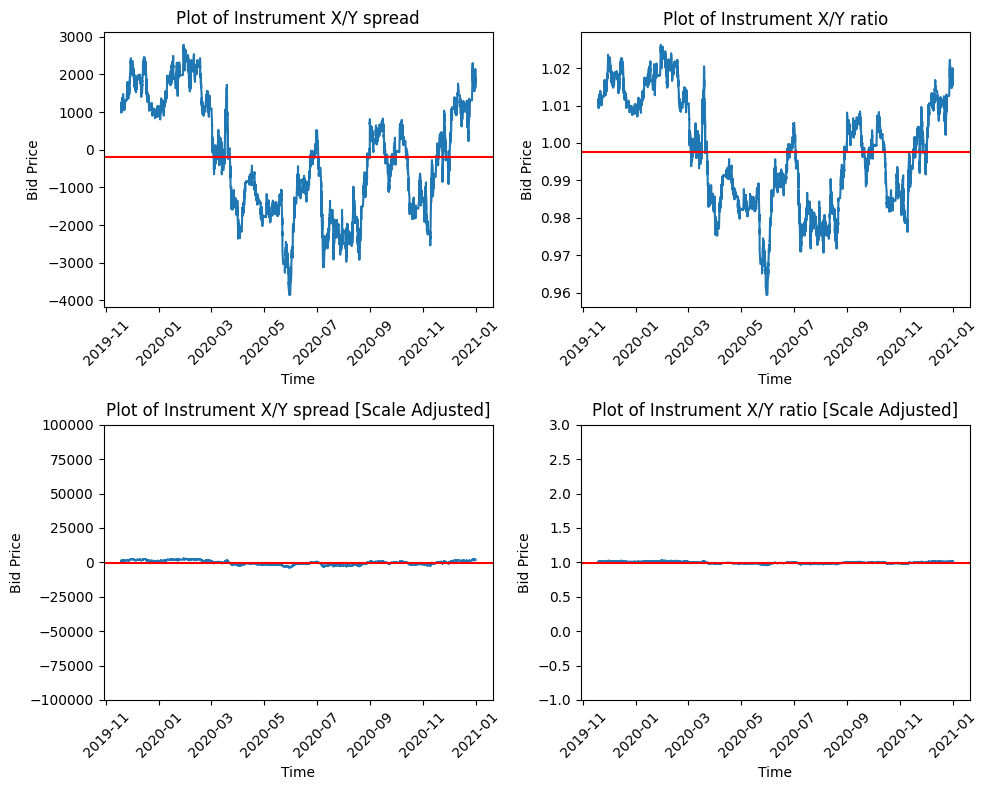

In [9]:
'''
Plotting the spread and ratio
If we plot the spread and ratio between the two instruments, we see that it is 
relatively constant when the scale of the data is taken into consideration and 
seems to fluctuate about a central mean (shown in red).
'''

xy_spread = midprices['X_MID'] - midprices['Y_MID']
xy_ratio = midprices['X_MID'] / midprices['Y_MID']

fig, ((top_left, top_right), (bottom_left, bottom_right)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Spread (Top-left)
top_left.plot(midprices.index, xy_spread, label="Spread")
top_left.set_title('Plot of Instrument X/Y spread')
top_left.set_xlabel('Time')
top_left.set_ylabel('Bid Price')
top_left.axhline(xy_spread.mean(), color='red')
plt.setp(top_left.get_xticklabels(), rotation=45)

# Ratio (Top-right)
top_right.plot(midprices.index, xy_ratio, label="Ratio")
top_right.set_title('Plot of Instrument X/Y ratio')
top_right.set_xlabel('Time')
top_right.set_ylabel('Bid Price')
top_right.axhline(xy_ratio.mean(), color='red')
plt.setp(top_right.get_xticklabels(), rotation=45)

# Spread w/ Adjusted Scale (Bottom-left)
bottom_left.plot(midprices.index, xy_spread, label="X_MID")
bottom_left.set_title('Plot of Instrument X/Y spread [Scale Adjusted]')
bottom_left.set_xlabel('Time')
bottom_left.set_ylabel('Bid Price')
bottom_left.axhline(xy_spread.mean(), color='red')
bottom_left.set_ylim(-100000, 100000)
plt.setp(bottom_left.get_xticklabels(), rotation=45)

# Ratio w/ Adjusted Scale (Bottom-right)
bottom_right.plot(midprices.index, xy_ratio, label="Y_MID")
bottom_right.set_title('Plot of Instrument X/Y ratio [Scale Adjusted]')
bottom_right.set_xlabel('Time')
bottom_right.set_ylabel('Bid Price')
bottom_right.axhline(xy_ratio.mean(), color='red')
bottom_right.set_ylim(-1, 3)
plt.setp(bottom_right.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## Validating Stationarity
In the above graph, we observe that the spread and ratio between the instruments X and Y appear to fluctuate around their respective means and **revert back to this mean**. It is important to be mislead by the scale of the data *(See above the same plots, but with adjusted y-axis so that the fluctuation of the price is contextualised accurately)*.

---

In this section, we will use various statistical tests to validate this stationarity, with techniques from *time-series analysis*.
Whilst on the above plot, the spread between them appears to be constant, varying ± $3000 over the course of a little more than a year. When we are dealing with instruments with prices above 100,000, we can hypothesise that this variation is negligible. 

***We will validate that the relationship between the two instruments shows stationairity using two methods.***
1. Cointegration test on X midprice and Y midprice
2. Augmented Dickey-Fulley test on the spread and ratio

In [10]:
'''
[1] Let's now perform a COINTEGRATION TEST between the two financial instruments to 
validate whether or not the spread remains stable/mean reverting. 

H₀: The instruments are not cointegrated. 

H₁: The instruments are cointegrated (the residual is stable)
'''

import statsmodels.tsa.stattools as ts 

# Perform cointegration test on midprices of X and midprices of Y
# Resample the data to a lower frequency (EVERY 5 MINUTES) and remove empty cells
midprices_resampled = midprices.resample('5T').mean().dropna() 
results = ts.coint(midprices_resampled['X_MID'], midprices_resampled['Y_MID'])

# Significance Level 
if results[1] < 0.05:
    print(f"Instruments X and Y are cointegrated (p-value: {round(results[1], 3)})")
else: 
    print(f"Instruments X and Y are NOT cointegrated (p-value: {round(results[1], 3)})")

Instruments X and Y are NOT cointegrated (p-value: 0.092)


In [11]:
# Resample the data to a different lower frequency (EVERY 2 DAYS) and remove empty cells
midprices_resampled = midprices.resample('2D').mean().dropna() 
results = ts.coint(midprices_resampled['X_MID'], midprices_resampled['Y_MID'])

# Significance Level 
if results[1] < 0.05:
    print(f"Instruments X and Y are cointegrated (p-value: {round(results[1], 3)})")
else: 
    print(f"Instruments X and Y are NOT cointegrated (p-value: {round(results[1], 3)})")

Instruments X and Y are cointegrated (p-value: 0.023)


It was found that the results of the cointegration test were sensitive to the frequency at which the prices were sampled. At a frequency of **5 minutes**, the two instruments did not pass the cointegration test (p-value 0.092), while at a frequency of **2 days**, they did pass (p-value 0.023).

***This leads to the following insights about the data:***
- The financial instruments themselves are non-stationairy, and thus introducing non-stationairy behaviour at higher frequencies. 
- At higher frequencies, market microstructure effects such as bid-ask spread, order flow and liquidity may be explaining the higher p-values. 
- The economic/market drivers influencing the relationship between instruments X and Y are more apparent at lower frequencies


**The second method is to perform an ADF (Augmented Dickey-Fuller) test on both the spread and ratio between the two instruments X and Y.** <br>
This is based on the reasoning that if the (mid)prices of X and Y are correlated, then they should move together and their difference and ratio should be constant. 

In [12]:
'''
[2] Perform ADF test on the spread and ratio between midprices of Instrument X and Y

H₀: The spread/ratio is non-stationairy
    
H₁: The spread/ratio is stationairy
'''

from statsmodels.tsa.stattools import adfuller

# Resample the data to suit adfuller algorithm, taking hourly samples
midprices_spread = (midprices['X_MID'] - midprices['Y_MID']).resample('H').mean().dropna()
midprices_ratio = (midprices['X_MID'] / midprices['Y_MID']).resample('H').mean().dropna() 

# Significance Level     
print("P-value for ADF on spread (X - Y): ", 
      round(adfuller(midprices_spread)[1], 3))

print("P-value for ADF on ratio (X / Y): ", 
      round(adfuller(midprices_ratio)[1], 3))

P-value for ADF on spread (X - Y):  0.188
P-value for ADF on ratio (X / Y):  0.159


# Results and Pricing Relations

- The spread and ratio exhibit weak stationarity, indicating a relatively stable long-term relationship between the two instruments.
- They tend to stay within a tight range.
- It's important to consider that factors such as the COVID pandemic might have introduced unusual market dynamics, affecting the relationship between X and Y.

In other words, although the individual instruments may have trends or drifts, their long-term relationship remains stable, as they move together to maintain this equilibrium. Deviations from the long-term relationship are temporary, and the time series will eventually revert to their equilibrium relationship.

We are more interested in the stationarity of the ratio rather than its specific value. The mean of the ratio X/Y is very close to 1.0 (0.998), but the key point is that the ratio remains relatively constant in the long term.

--- 

To summarise: 
- The main **relationship** found in the previous step was that the mid prices of the two instruments were highly correlated (0.979), and that their time series had a strong but not definite cointegration (ADF p-value of 0.159 for ratio). 
- The main **pattern** discovered in the previous step was that the mid prices of the two instruments tend to eventually converge back to a given mean. 

Based on this information, we can hypothesise pricing signals assuming that if the mid prices of the instruments diverge, they will eventually converge back to a certain mean. Therefore, a pairs trading strategy is appropriate.

---

One approach is to standardise the data and assign respective signals whenever the spread or ratio deviates by more than one standard deviation from the mean. Either the spread or ratio can be used for this strategy. In this analysis, we will use the ratio.

$$ Ratio = \frac{\text{Mid price of X}}{\text{Mid price of Y}} $$

**This behaviour is best seen on a standardised plot of the X/Y price ratio:**

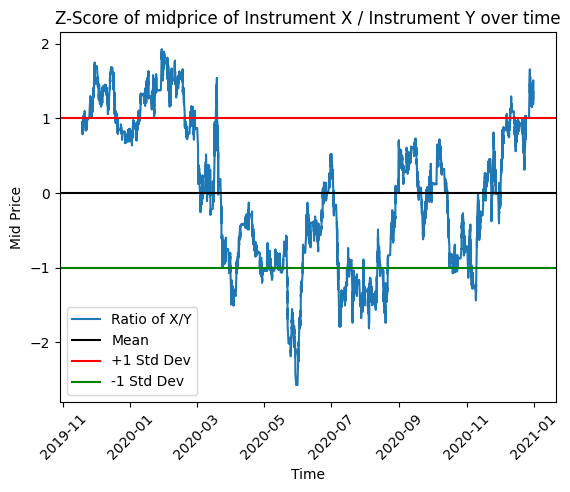

In [13]:
# STANDARDISED RATIO BETWEEN INSTRUMENT X AND Y

midprices['XY_RATIO'] = midprices['X_MID'] / midprices['Y_MID']
plt.plot(midprices.index, (midprices['XY_RATIO']-midprices['XY_RATIO'].mean())/midprices['XY_RATIO'].std(), 
         label="Ratio of X/Y")
plt.title('Z-Score of midprice of Instrument X / Instrument Y over time')
plt.xlabel('Time')
plt.ylabel('Mid Price')

plt.axhline(y=0, color = 'black', label='Mean')
plt.axhline(1.0, color='red', label='+1 Std Dev') 
plt.axhline(-1.0, color='green', label='-1 Std Dev') 

plt.legend()
plt.xticks(rotation=45)
plt.show()

*In general, our assumption is that any ratio values that deviate too far from the mean (say, 1.5 SD's) must eventually 'revert' back to the mean, based on the assumption that X and Y are correlated long term.*

Our plan is to exploit this normal distribution by short selling instrument X when it is overvalued and simeltaneously buying instrument Y when it is undervalued (and vice versa) with the hopes that we profit in both directions when the prices of the two instruments eventually converge back to the mean... 

*(A mis-valuation is represented by a unusually high/low z-score of the ratio X/Y).

# Part C: Pricing Signals & Trading Strategy

Pairs trading is a market neutral strategy but that does not mean it requires no thought. While we know that the general objective is to buy in when the prices of the instruments diverge (given by change in spread/ratio), the art is **determining the optimal time to go long / short on Instrument X and Y in order to maximise our return.**

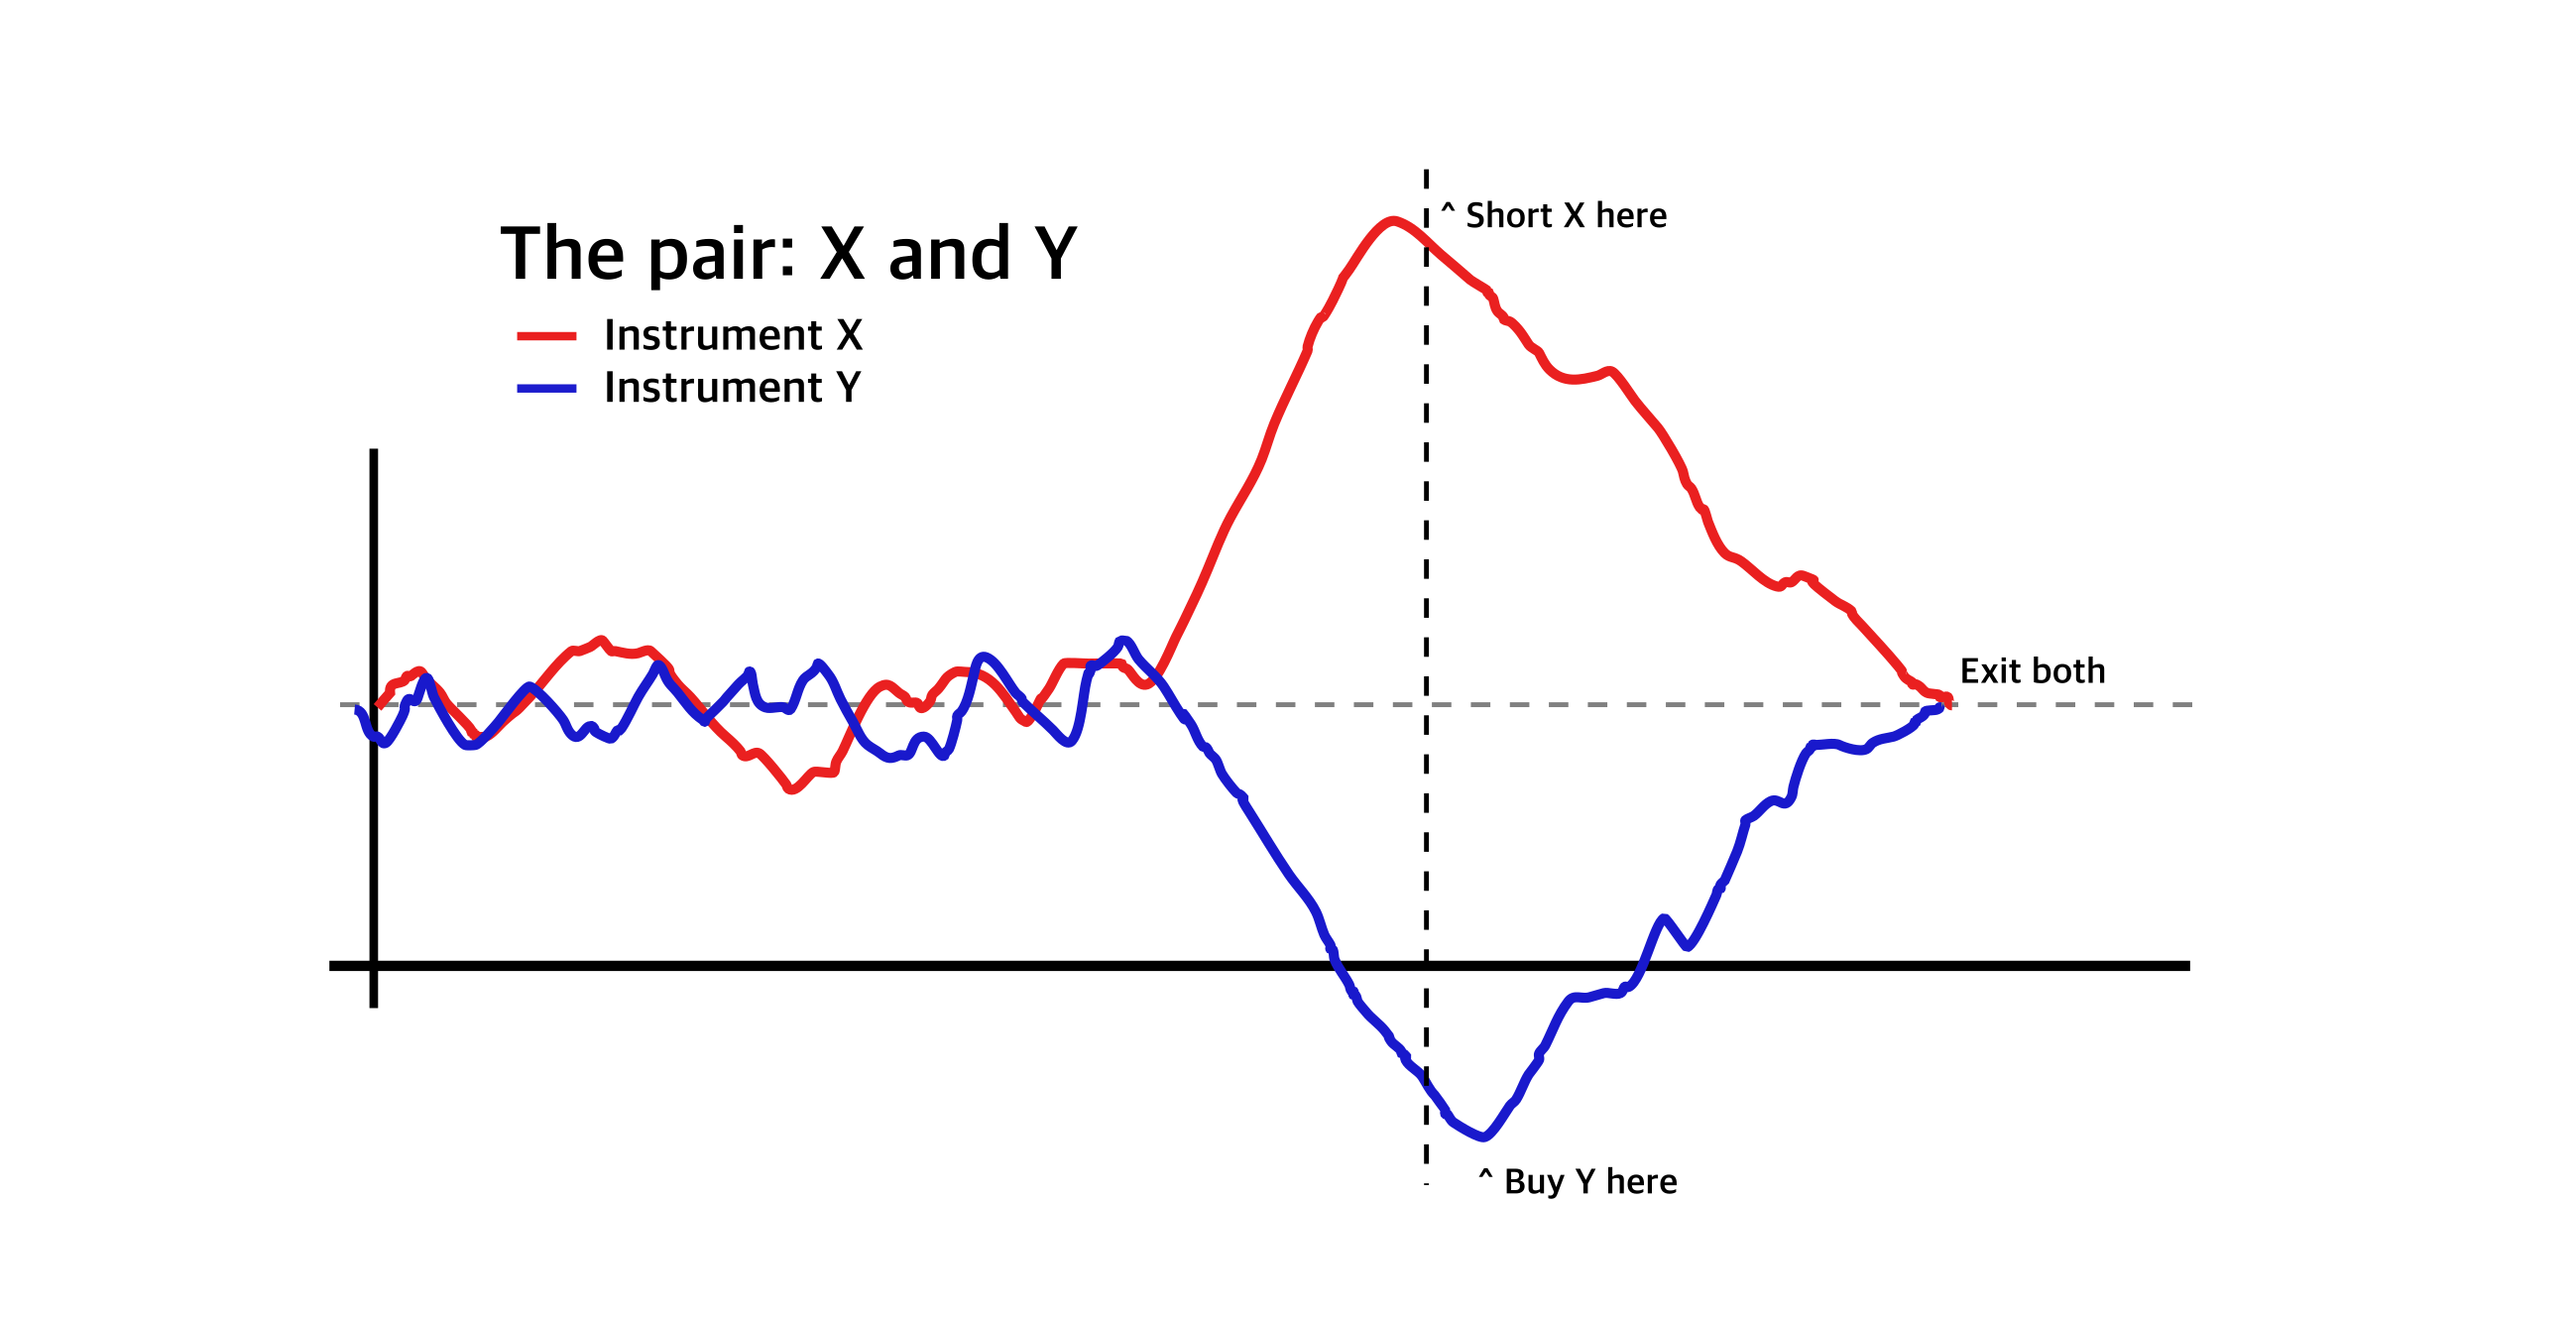
*Image: A highly simplified example of an optimal trade on Instruments X and Y*

### But how do we know when to buy/sell?

The hard part is knowing when to enter and exit. Our two options are to: long the XY pair or short the XY pair. The fundamental principle of pairs trading is that you buy (whether it be long/short) when a divergence emergences between the price of X and Y. 

---

The ideal method would be to train a machine learning model (linear regression) in order to determine our trading signals, recognising the peaks and cusps of the ratio. *I tried but failed to implement a machine learning linear regression model which identified the optimal buy and sell times, mostly because I struggled to identify which features to feed into it, and how to generate a trainable target variable; I struggled to train an ML model to identify the best pricing signals without knowing what they were in the first place, or having any tangible data representing them. This could have been combatted through backtraining.*

---

The revenue from the short sale can help cover the cost of the long position, making the pairs trade inexpensive to put on. Position size of the pair should be matched by dollar value rather than by the number of shares; this way a 5% move in one equals a 5% move in the other.

*Before we discuss how the pricing signals are generated, some basic data massaging is needed: *

In [14]:
# DATA PREPROCESSING | Rolling averages | Resample | Standardise  

# All relevant features and data will be stored in the dataframe processed_data
processed_data = pd.DataFrame(index=all_data.index)
processed_data['X_MID'] = midprices['X_MID']
processed_data['Y_MID'] = midprices['Y_MID']

# Ratio between mid prices of X and Y
processed_data['XY_RATIO'] = processed_data['X_MID'] / processed_data['Y_MID']

# Resample data per day 
processed_data = processed_data.resample('D').mean().dropna()

# Rolling averages
processed_data['ROLL_AVG_SML'] = processed_data['XY_RATIO'].rolling(window=1).mean()
processed_data['ROLL_AVG_LRG'] = processed_data['XY_RATIO'].rolling(window=30).mean()
processed_data['ROLL_AVG_LRG_STD'] = processed_data['XY_RATIO'].rolling(window=30).std()

# Standardising | Calculate the z-score of the ratio
processed_data['Z_SCORE'] = (processed_data['XY_RATIO']-processed_data['XY_RATIO'].mean()) / processed_data['XY_RATIO'].std()
# Standardise the narrow rolling average against the wider rolling average
processed_data['RA_Z_SCORE'] = (processed_data['ROLL_AVG_SML']-processed_data['ROLL_AVG_LRG'])/processed_data['ROLL_AVG_LRG_STD']

### GENERATING PRICING SIGNALS FROM MOVING AVERAGES | Z-SCORE

**Rolling Average**

*"Rolling average window - For high-frequency trading or intraday trading strategies, smaller windows may be more appropriate, as they capture short-term trends and allow for more frequent trading signals. However, for longer-term strategies or for financial instruments with lower intraday volatility, larger windows may be more suitable."*

**Overview:** 
- Instead of generating pricing signals by flagging any ratios that are a certain number of standard deviations away from the mean, another level of complexity is added through rolling averages. 
- The reasoning is that values from the smaller (1 day) rolling average prediction that exceed the more stable, larger (30 day) rolling average forecast by a certain threshold are flagged.
- These thresholds are adjustable. 
- This method also omits any signals that would have been generated too close the mean, in this case 0.5 standard deviations. 
- There is also an adjustable exit threshold which simply assigns exit signals to ratios near the mean

In [15]:
entry_threshold = 1.5  # Threshold for entering a trade
exit_threshold = 0.5  # Threshold for exiting a trade

processed_data['SIGNAL'] = None # Hold otherwise 

# Short X/Y pair
processed_data.loc[(processed_data['RA_Z_SCORE'] > entry_threshold) & (processed_data['Z_SCORE']>0.5), 'SIGNAL'] = -1  # Short the spread
# Long X/Y pair
processed_data.loc[(processed_data['RA_Z_SCORE'] < -entry_threshold) & (processed_data['Z_SCORE']<-0.5), 'SIGNAL'] = 1  # Long the spread
# Exit 
processed_data.loc[(-exit_threshold < processed_data['RA_Z_SCORE']) & (processed_data['RA_Z_SCORE'] < exit_threshold), 'SIGNAL'] = 0  # Close the position

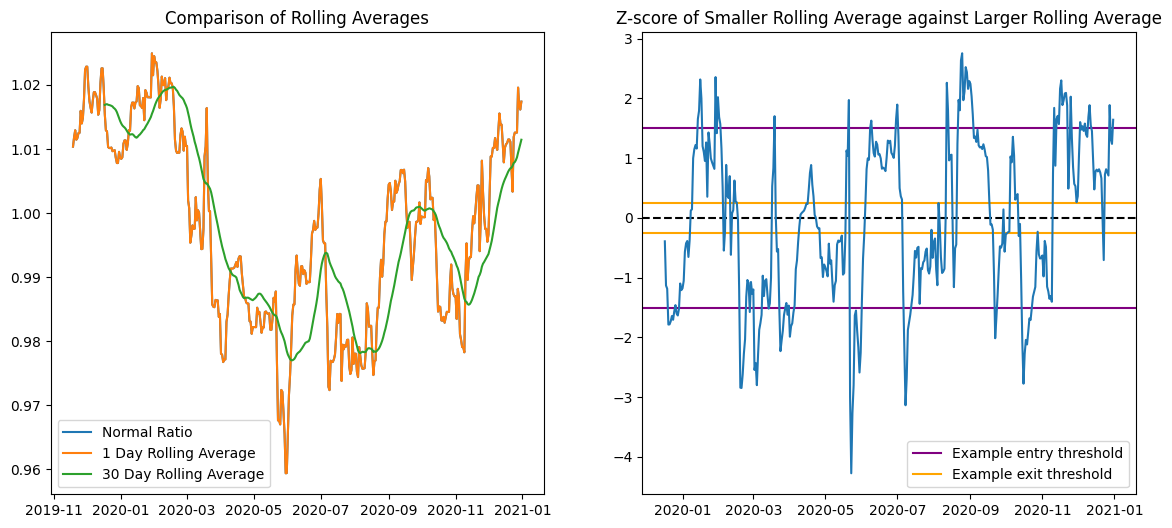

In [16]:
plt.figure(figsize=(14, 6))

# First subplot: Rolling Averages Comparison
plt.subplot(1, 2, 1)
plt.title("Comparison of Rolling Averages")
plt.plot(processed_data['XY_RATIO'], label='Normal Ratio')
plt.plot(processed_data['ROLL_AVG_SML'], label='1 Day Rolling Average')
plt.plot(processed_data['ROLL_AVG_LRG'], label='30 Day Rolling Average')
plt.legend()

# Second subplot: Standardized Rolling Averages Visualized
plt.subplot(1, 2, 2)
plt.title('Z-score of Smaller Rolling Average against Larger Rolling Average')

plt.axhline(1.5, color='purple', label='Example entry threshold')
plt.axhline(0.25, color='orange', label='Example exit threshold')
plt.axhline(-1.5, color='purple')
plt.axhline(-0.25, color='orange')
plt.axhline(0, color='black', linestyle='--')

plt.plot(processed_data['RA_Z_SCORE'])
plt.legend()

# Show the figure with both subplots
plt.show()


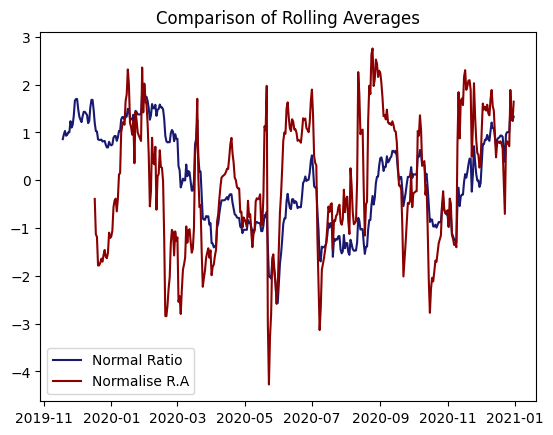

In [24]:
# First subplot: Rolling Averages Comparison
plt.figure()
plt.title("Comparison of Rolling Averages")
plt.plot(processed_data['Z_SCORE'], label='Normal Ratio', color='midnightblue')
plt.plot(processed_data['RA_Z_SCORE'], label='Normalise R.A', color='darkred')
plt.legend()


# Show the figure with both subplots
plt.show()


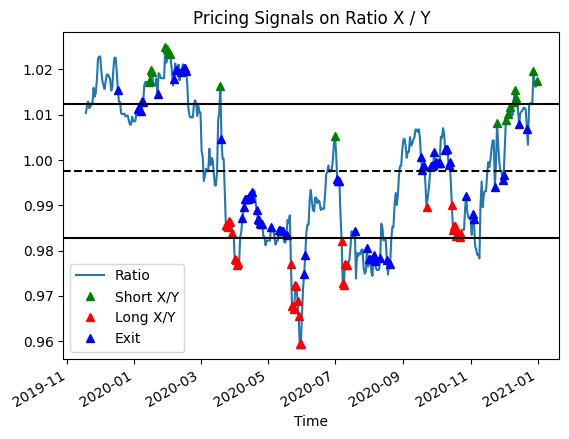

In [18]:
# PLOTTING THE SIGNALS
plt.plot(processed_data['XY_RATIO'])

# Duplicate values 
shrt = processed_data['XY_RATIO'].copy()
long = processed_data['XY_RATIO'].copy()
exit = processed_data['XY_RATIO'].copy()

# Erase all values that are not marked with a signal
shrt[processed_data['SIGNAL'] != -1] = None
long[processed_data['SIGNAL'] != 1] = None
exit[processed_data['SIGNAL'] != 0] = None

shrt.plot(color='g', linestyle='None', marker='^')
long.plot(color='r', linestyle='None', marker='^')
exit.plot(color='b', linestyle='None', marker='^')

x1, x2, y1, y2 = plt.axis()
plt.axhline(processed_data['XY_RATIO'].mean(), color='black', linestyle='--') 
plt.axhline(processed_data['XY_RATIO'].mean()+processed_data['XY_RATIO'].std(), color='black') 
plt.axhline(processed_data['XY_RATIO'].mean()-processed_data['XY_RATIO'].std(), color='black')
plt.legend(['Ratio', 'Short X/Y', 'Long X/Y', 'Exit'])
plt.title('Pricing Signals on Ratio X / Y')
plt.show()

- Clearly, this is an imperfect algorithm for generation pricing signals. Many signals contradict, and it does not capitalise fully on every single peak and cusp of the instruments price movents. <br>
- Nonetheless, it does well in the extremes, and knows to buy in when the prices of the X and Y diverge significantly from the mean, and to exit when they converge again. <br>
- However, we will show through simulation in the following section that this is a crude yet effective method for predicting future movements from past prices. 

*1. Note that green/red does not mean buy and sell, rather short or long* <br>
*2. The 3 black lines represent the mean and -1/+1 standard deviations of the ratio X/Y*

### Simulation Time 

*Note that there is no need to backtest this strategy since it only uses the previous X days to compute the rolling average.*

This is an **extremely simplified simulation environment** and thus yield exaggerated results
For simplicity, we will ignore bid/ask price and volume and assume that:
- When a buy signal is encountered, one unit of each respective instrument is shorted / bought. 
- When an exit signal is encountered, all current holdings are sold no matter how many.  
- Any trade can be executed instantaneously by asking or selling at the midprice
- No transcational cost or friction
- Initial capital is irrelevant, since exact proceeds from short selling go towards long buy. Of course, in the real world, there are limitations on this capital and risk, otherwise we would have a money making machine. 

In [19]:
# TRADING SIMULATION NOV 2019 - JAN 2021
curr_profit = 0
processed_data['PROFIT'] = None
# Portfolio value consists of the market value of any stocks held. Profit 


x_long = 0
x_short = 0
y_long = 0
y_short = 0

# Iterate through
for indx, row in processed_data.iterrows():
    
    # Short X and Long Y 
    if row['SIGNAL'] == 1:
        x_short += 1      
        y_long += 1
        # No expense since short sell covers the long buy
        processed_data.at[indx, 'PROFIT'] = curr_profit + x_long*row['X_MID']+y_long*row['Y_MID']-x_short*row['X_MID']-y_short*row['Y_MID']
        
    # Long X and Short Y
    elif row['SIGNAL'] == -1:
        y_short += 1
        x_long += 1    
        # No expense since short sell covers the long buy
        processed_data.at[indx, 'PROFIT'] = curr_profit + x_long*row['X_MID']+y_long*row['Y_MID']-x_short*row['X_MID']-y_short*row['Y_MID']
        
    # Exit, sell all
    elif (row['SIGNAL'] == 0) & (x_long+x_short+y_long+y_short > 0):
        curr_profit += x_long*row['X_MID']
        curr_profit += y_long*row['Y_MID']
        curr_profit -= x_short*row['X_MID']
        curr_profit -= y_short*row['Y_MID']
        
        processed_data.at[indx, 'PROFIT'] = curr_profit
        
        x_long, y_long, x_short, y_short = 0, 0, 0, 0
        
    # Otherwise, hold
    else:
        processed_data.at[indx, 'PROFIT'] = curr_profit + x_long*row['X_MID']+y_long*row['Y_MID']-x_short*row['X_MID']-y_short*row['Y_MID']

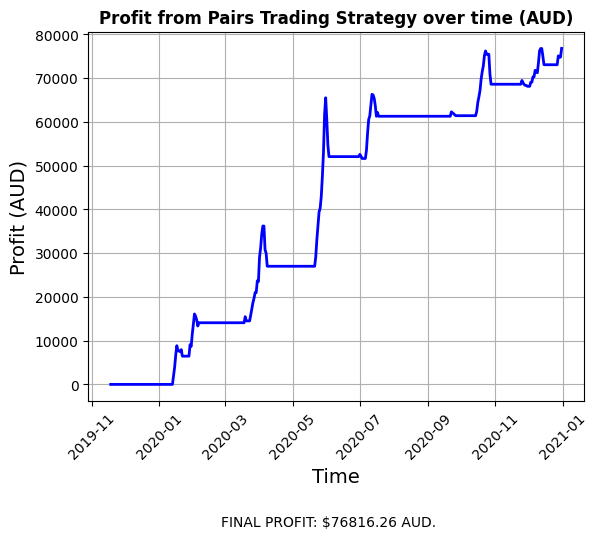

In [20]:
plt.plot(processed_data['PROFIT'], color='blue', linewidth=2)  

plt.title('Profit from Pairs Trading Strategy over time (AUD)', fontsize=12, fontweight='bold')  
plt.xlabel('Time', fontsize=14)  
plt.ylabel('Profit (AUD)', fontsize=14) 

plt.grid(True)  
plt.xticks(rotation=45)
plt.figtext(0.5, -0.15, f"FINAL PROFIT: ${round(processed_data['PROFIT'].iloc[-1], 2)} AUD.", ha="center")
plt.show()

# Evaluation

### Monetisation of Strategy
The effectiveness of the strategy is demonstrated through simulations; however, caution should be exercised when interpreting the results. Results from the simulation are highly exaggerated due to numerous factors. 

### Limitations 

There were a few limitations to the implented pairs trading **strategy**. 

A major limitation was that the volume data was not factored into the analysis in any way, however this was partly due to its lack of richness in information and relevancy. In the future, it could be used as a feature for a machine learning model which predicted the pricing signals.

Furthermore, no inventory management was implemented, or risk management techniques such stop-losses. 

Another limitation was that there were numerous important parameters that were not explored or fine tuned, namely: 
- Resample frequency
- Thresholds for entry/exit
- Size of rolling average windows:

**A few examples with varied parameters:**

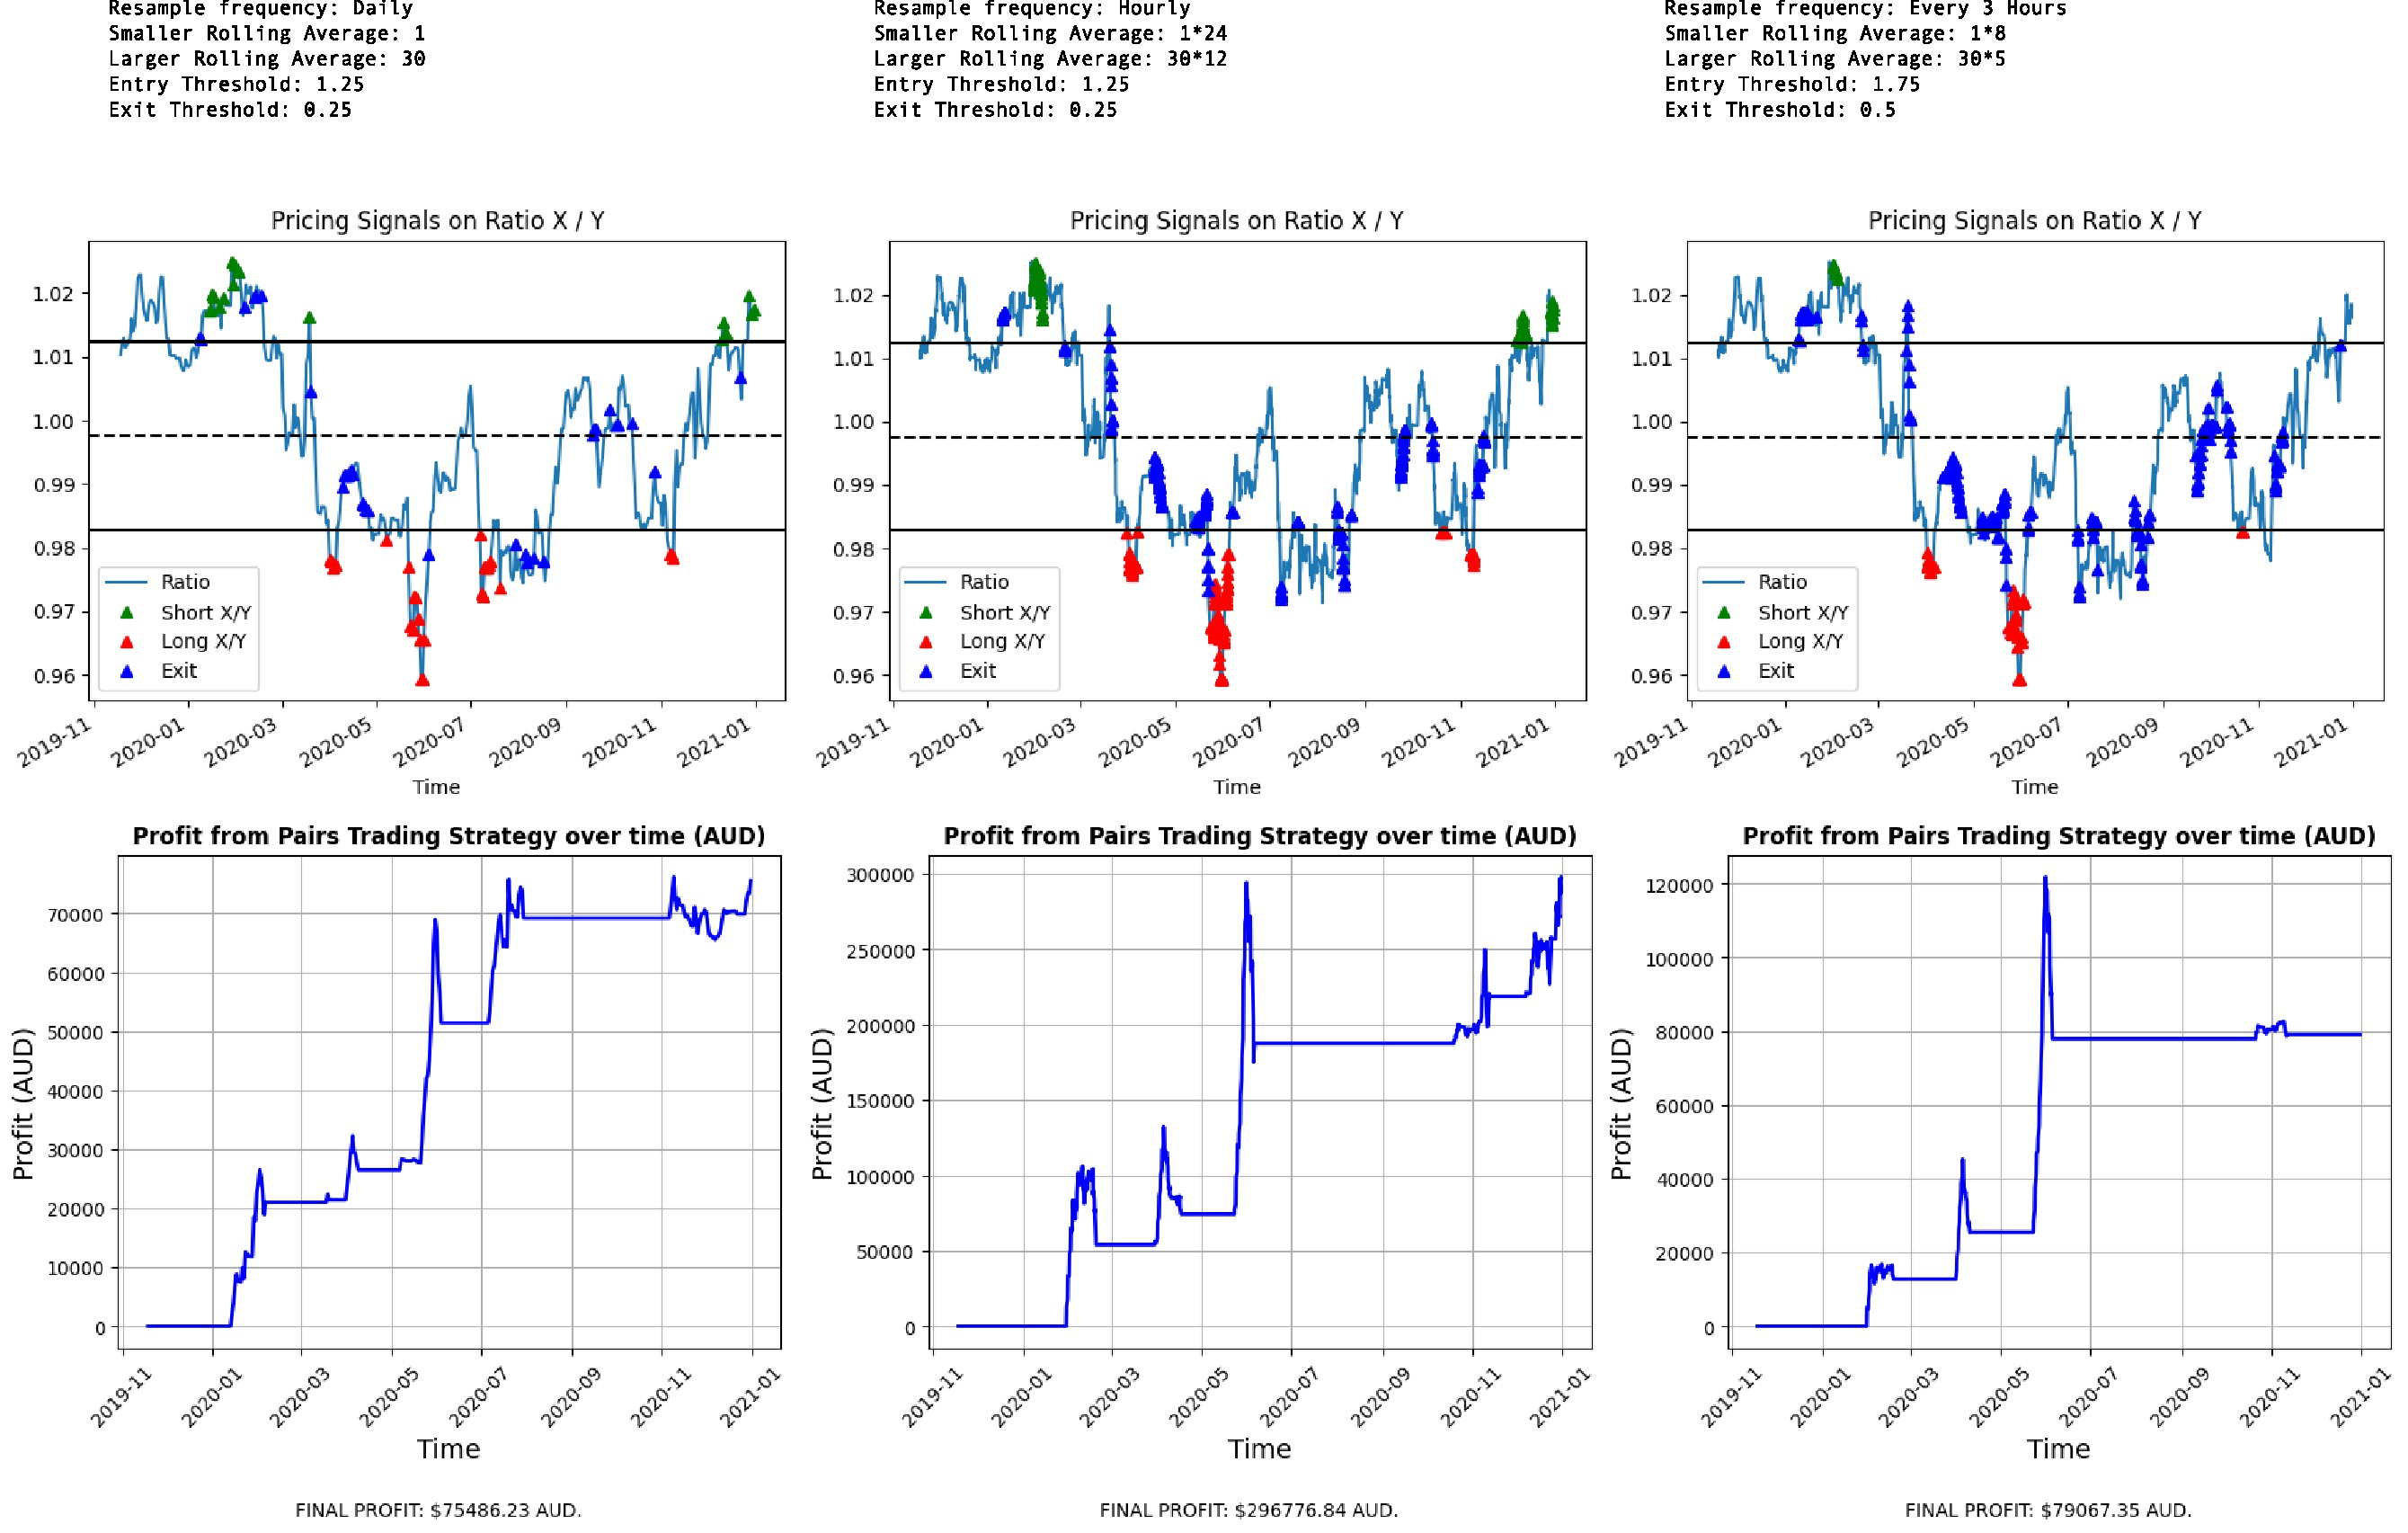

---

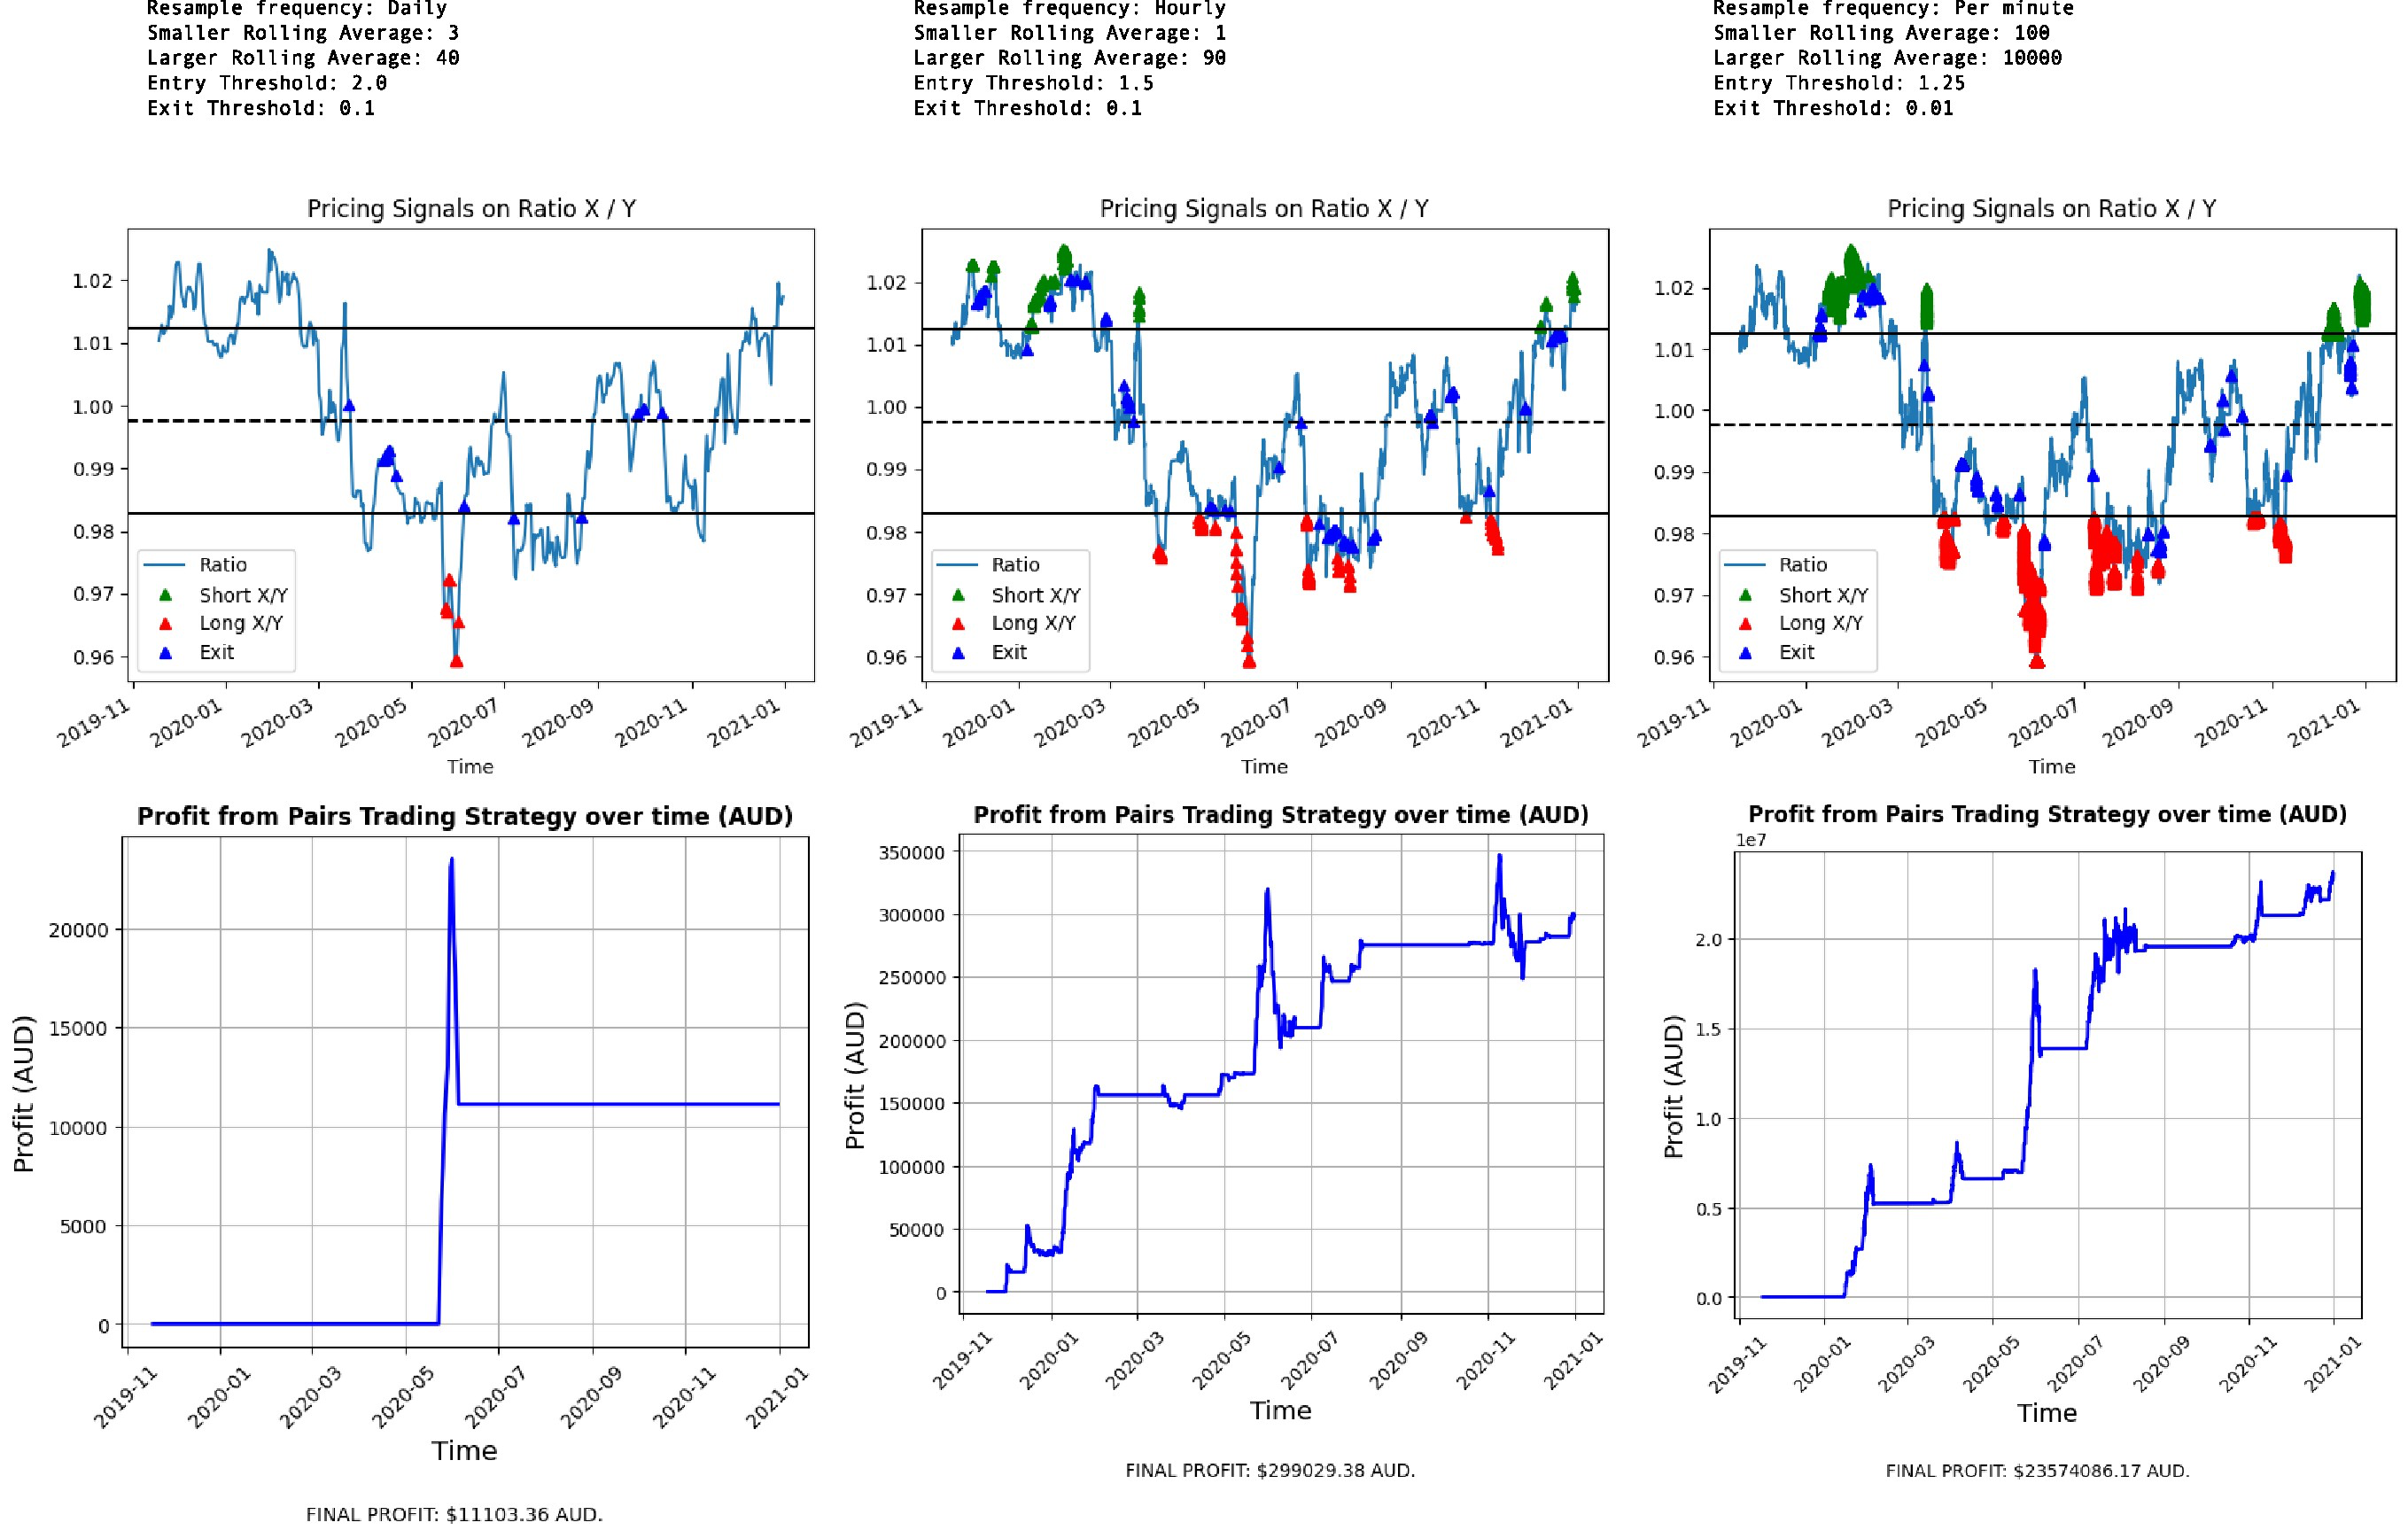

### Insights
- The resample frequency can make the strategy more realistic.
- The thresholds can fine-tune the strategy to make it more aggressive or conservative.
- The moving average windows can be adjusted based on the desired trading frequency and instrument characteristics.
- We see that strategies with higher frequencies yield higher profits because they simply enable a larger position to be held (more inventory of each instrument X and Y) and thus more profit to be made; bottom right #6 is clearly the result of no limits

In summary, the simulation is limited and biases strategies that involve more signals. Our analysis of the strategy is largely limited by the simplicity of the simulation code. Additionally, it does not account for transaction costs, slippage, or other real world trading considerations. 

The results shown represent a best case scenario, and those world trading factors would diminish the magnitude of profit. However, they nonetheless prove the viability of the pairs trading strategy on the two instruments X and Y, and is able to exploit the temporary divergence of only a few thousand dollars (± $3000), by short selling one instrument and buying the other. This strategy is justified by our analysis that the prices of the two instruments are both **highly correlated** and demonstrate some **cointegration**. In the future, it is hypothesised that their cointegration would increase, due to more steady market conditions than the period 2019-2021.  

---

### Metrics that could be used to evaluate effectiveness of strategy
- Cumulative Returns: Total returns of the pairs trading strategy, showing overall profitability in exploiting price convergences.
- Annualized Returns: Average yearly returns of the strategy, useful for comparing its performance with other pairs trading approaches or time horizons.
- Win Rate: Proportion of winning trades in the strategy; higher win rates suggest better predictions of price convergences in instruments X and Y.
- Average Gain and Average Loss: Average profit and loss per trade in the pairs trading strategy; higher average gains relative to losses indicate effective exploitation of price convergences and risk management.
- Risk-Reward Ratio: Compares average gain to average loss in the context of the pairs trading strategy; higher ratios signify better returns for the risks taken in betting on price convergences.

### Potential areas of further research

- As mentioned earlier, using an ML model to generate pricing signals might lead to better outcomes.
- Investigating other features, relationships, or statistical measures to identify pricing signals.
- Incorporating volume data into the strategy.
- Incorporate bid/ask prices rather than using only the **mid price** to represent prices of X and Y
- Comparing the strategy's performance to alternative strategies or benchmarks